# 20/12/2024 - TP Evalué ESNbyUM

L’objectif de ce TP est : 
- Extraire les informations liées à des articles de PubMed
- Sauvegarder cette extraction dans un dataset
- Prétraiter 
- Analyser
### Le TP est à réaliser sur un notebook où vous commenterez votre code. Le rendu se fera sur GitHub.

# Web Scraping
## Recherchez des articles scientifiques sur PubMed en utilisant un mot-clé spécifique et extrayez les informations suivantes :
- Titre de l’article.
- Résumé (abstract).
- Auteurs.

Adaptez votre script pour itérer sur plusieurs pages afin de récupérer davantage d’articles. Stockez ensuite ces informations dans un dataframe.

Dans un premier temps, nous importons toutes les bilbiothèques dont nous allons voire usage dans la suite du code

In [ ]:
import requests # sera utilisé pour le web scraping
from bs4 import BeautifulSoup # sera utilisé pour le web scraping
import nltk # sera utilisé pour le traitement de texte
from nltk.corpus import stopwords # pour les stopwords
from nltk.tokenize import word_tokenize  # pour la tokenization
from nltk.stem import WordNetLemmatizer # pour la lemmatization
from wordcloud import WordCloud # pour la visualisation
import matplotlib.pyplot as plt # pour la visualisation
from collections import Counter # pour la visualisation
import csv # pour l'exportation des données
import re # pour les expressions régulières

Nous définissions ensuite 3 fonctions, qui seront appelées plus tard :
- Une fonction d'extraction des informations (titre, abstract et auteurs) contenu dans un article depuis un url
- Une fonction servant à extraire les url des résulats de recherche présent sur une page
- Une fonction qui crée et complète un document .csv avec les informations récoltées plus tôt

In [13]:
# Fonction pour extraire les informations d'un article PubMed
def extract_article_info(pubmed_url): 
    response = requests.get(pubmed_url) # Récupérer la page web
    if response.status_code == 200: # Si la page est récupérée avec succès
        soup = BeautifulSoup(response.text, 'html.parser') # Parser la page web avec BeautifulSoup
        # Extraire le titre
        title = soup.find('h1', class_='heading-title')
        title = title.get_text(strip=True) if title else 'Titre non trouvé' # Si le titre est trouvé, extraire le texte, sinon afficher 'Titre non trouvé'
        
        # Extraire abstract
        abstract = soup.find('div', class_='abstract-content selected') # Trouver la balise div avec la classe 'abstract-content selected'
        abstract = abstract.get_text(strip=True) if abstract else 'Résumé non trouvé' # Si le résumé est trouvé, extraire le texte, sinon afficher 'Résumé non trouvé'
        
        # Extraire  authors
        authors = soup.find('div', class_='authors-list') # Trouver la balise div avec la classe 'authors-list'
        if authors: # Si les auteurs sont trouvés
            authors_list = authors.find_all('a') # Trouver toutes les balises 'a' dans la balise 'div'
            author_names = [author.get_text(strip=True) for author in authors_list] # Extraire le texte de chaque balise 'a'
            authors = ', '.join(author_names) # Joindre les noms des auteurs avec une virgule
        else:
            authors = 'Auteurs non trouvés'  # Si les auteurs ne sont pas trouvés, afficher 'Auteurs non trouvés'

        return {
            'title': title, 
            'abstract': abstract,
            'authors': authors
        }
    return {'error': 'Erreur lors de la récupération de la page'} # Si la page n'est pas récupérée avec succès, retourner un dictionnaire avec un message d'erreur

# Fonction extraire url des articles à partir d'une page PubMed
def get_article_urls(search_url, max_pages): # max_pages est le nombre de pages à scraper
    article_urls = [] # Initialiser une liste pour stocker les URLs des articles
    for page in range(1, max_pages + 1): # Pour chaque page de 1 à max_pages
        url = f'{search_url}&page={page}' # Construire l'URL de la page
        response = requests.get(url) # Récupérer la page web
        if response.status_code == 200: # Si la page est récupérée avec succès
            soup = BeautifulSoup(response.text, 'html.parser') # Parser la page web avec BeautifulSoup
            articles = soup.find_all('a', class_='docsum-title') # Trouver toutes les balises 'a' avec la classe 'docsum-title'
            for article in articles: # Pour chaque balise 'a'
                article_url = 'https://pubmed.ncbi.nlm.nih.gov' + article['href'] # Construire l'URL de l'article
                article_urls.append(article_url) # Ajouter l'URL à la liste des URLs des articles
    return article_urls

# Fonction pour scraper plusieurs et extraire informations
def scrape_pubmed(search_url, max_pages, output_csv='pubmed_articles.csv'): # max_pages est le nombre de pages à scraper
    article_urls = get_article_urls(search_url, max_pages) # Extraire les URLs des articles
    
    # Créer ou ouvrir .csv en  écriture
    with open(output_csv, mode='w', newline='', encoding='utf-8') as file: # Ouvrir le fichier en mode écriture
        writer = csv.writer(file) # Créer un objet writer
        writer.writerow(['Titre', 'Abstract', 'Auteurs']) # Écrire les en-têtes des colonnes
        
        # Extraire les informations de chaque article et les écrire dans un .csv
        for url in article_urls: # Pour chaque URL d'article
            article_info = extract_article_info(url) # Extraire les informations de l'article
            if 'error' not in article_info: # Si aucune erreur n'est survenue lors de l'extraction
                writer.writerow([article_info['title'], article_info['abstract'], article_info['authors']]) # Écrire les informations dans le fichier .csv




Une fois les fonctions préliminaires définis, nous pouvons les appeler, en demandant au préalable à l'utilisateur les paramètres de sa recherche (url et nombre maximum de page exploré)

In [14]:
# Demander à l'utilisateur de fournir une URL de recherche PubMed
search_url = input("Veuillez entrer l'URL de recherche PubMed : ")

# Demander à l'utilisateur de fournir le nombre maximum de pages à explorer
max_pages = int(input("Veuillez entrer le nombre maximum de pages à explorer : "))

# Scraper informations des articles et enregistrer dans .csv
scrape_pubmed(search_url, max_pages, output_csv='pubmed_articles.csv') # Scraper les max_pages premières pages et enregistrer les informations dans 'pubmed_articles.csv'

# Analyse Exploratoire et Prétraitement
Une fois les informations dans un dataframe, réalisez les tâches suivantes :
- Appliquez une pipeline de prétraitement (comme vu dans les TD) sur les résumés et les titres des articles. Les pipelines peuvent être différentes pour les deux champs.
- Après avoir appliqué ces pipelines :
- Créez un nuage de mots à partir des résumés.
- Calculez la fréquence des mots présents dans les résumés et réalisez une visualisation pour représenter cette distribution.

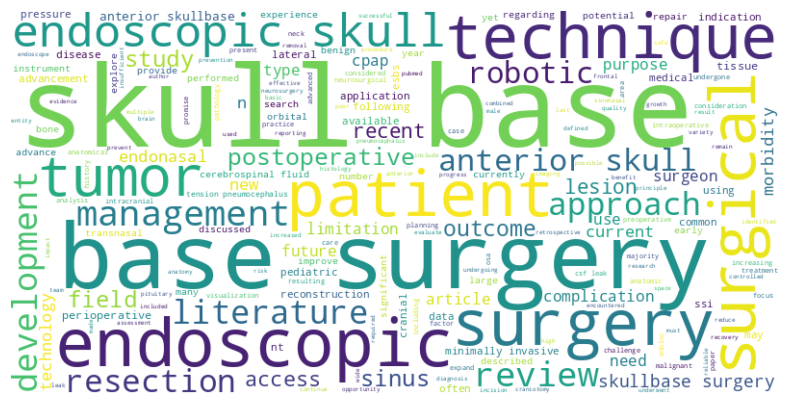

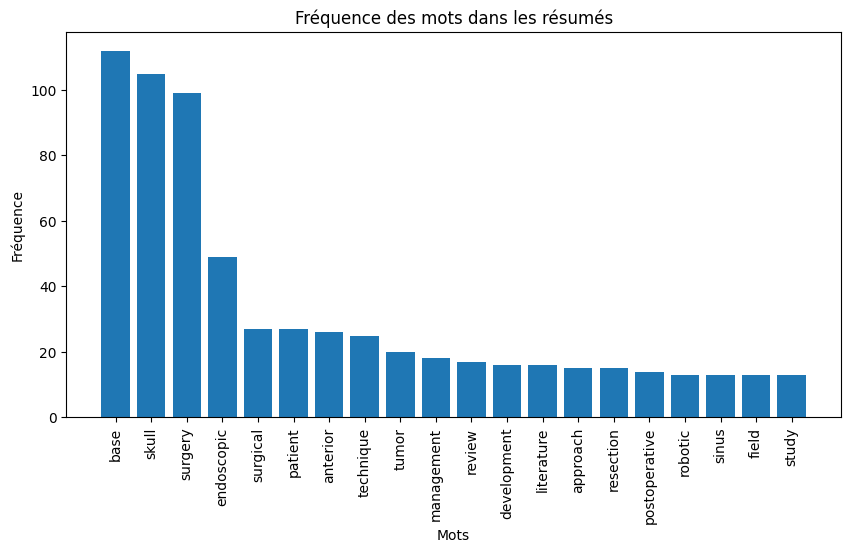

In [15]:
# Initialisation du lemmatizer et des stopwords
lemmatizer = WordNetLemmatizer() # Initialiser le lemmatizer
stop_words = set(stopwords.words('english')) # Initialiser les stopwords en choisissant la langue anglaise

# Fonction de prétraitement pour le titre
def preprocess_title(title):
    # Convertir en minuscule et supprimer la ponctuation
    title = title.lower() # Convertir en minuscule
    title = re.sub(r'[^\w\s]', '', title)  # Retirer la ponctuation
    # Tokeniser et lemmatiser
    tokens = word_tokenize(title) # Tokeniser le titre
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # Lemmatiser les tokens et retirer les stopwords
    return ' '.join(filtered_tokens) # Retourner les tokens lemmatisés sous forme de chaîne de caractères

# Prétraitement pour le résumé
def preprocess_abstract(abstract):
    # Convertir en minuscule et supprimer la ponctuation
    abstract = abstract.lower() # Convertir en minuscule
    abstract = re.sub(r'[^\w\s]', '', abstract)  # Retirer la ponctuation
    # Tokeniser et lemmatiser
    tokens = word_tokenize(abstract) # Tokeniser le résumé
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # Lemmatiser les tokens et retirer les stopwords
    return ' '.join(filtered_tokens) # Retourner les tokens lemmatisés sous forme de chaîne de caractères

# Créer le nuage de mots
def create_wordcloud(texts):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts)) # Créer un nuage de mots
    plt.figure(figsize=(10, 5)) # Créer une figure
    plt.imshow(wordcloud, interpolation='bilinear') # Afficher le nuage de mots
    plt.axis('off') # Désactiver les axes
    plt.show()

# Afficher la fréquence des mots
def plot_word_frequency(texts):
    # Joindre tous les textes
    all_text = ' '.join(texts) # Fusioner tous les résumés
    # Compter la fréquence des mots
    word_freq = Counter(all_text.split()) # Compter la fréquence des mots
    # Prendre les 20 mots les plus fréquents
    most_common = word_freq.most_common(20) # Prendre les 20 mots les plus fréquents
    
    # Visualiser les résultats
    words, freqs = zip(*most_common) # Diviser les mots et les fréquences
    plt.figure(figsize=(10, 5)) # Créer une figure
    plt.bar(words, freqs) # Créer un diagramme à barres
    plt.xticks(rotation=90)
    plt.xlabel('Mots')
    plt.ylabel('Fréquence')
    plt.title('Fréquence des mots dans les résumés')
    plt.show()

# Lire les résumés extraits depuis le CSV
abstracts = []
titles = []

# Charger les données à partir du .CSV
with open('pubmed_articles.csv', mode='r', encoding='utf-8') as file: # Ouvrir le fichier en mode lecture
    reader = csv.reader(file) # Créer un objet reader
    next(reader)  # Sauter l'en-tête
    for row in reader: # Pour chaque ligne dans le fichier
        titles.append(preprocess_title(row[0]))  # Titre
        abstracts.append(preprocess_abstract(row[1]))  # Résumé

# Créer un nuage de mots à partir des résumés
create_wordcloud(abstracts)

# Afficher la fréquence des mots dans les résumés
plot_word_frequency(abstracts)